# Convolution

**Astropy** provides comprehensive methods for convolution (with added benefits over those in the base `scipy` package). In this introductory notebook we'll use these methods to smooth some one and two dimensional datasets.

We first load our typical scientific libraries, the `fits` sublibrary, and the `convolve` and `convolve_fft` libraries

In [28]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [32]:
from astropy.io import fits
from astropy.convolution import convolve, convolve_fft, Box1DKernel

### Smoothing 1D data

To demonstrate 1D convolution we'll use the 3C 273 quasar spectral data from the modelling notebook. The code below loads the data, renormalises it, and creates an array of wavelength values.

In [33]:
hdu = fits.open('../data/3C_273-S-B-bcc2009.fits')[0]
flux = hdu.data / 10000

a = hdu.header['CRVAL1']
b = hdu.header['CRVAL1'] + hdu.header['CDELT1']*len(flux)

x = np.linspace(a, b, len(flux))

We now have to create an instance of our convolution kernel. `Box1DKernel` instantiates a simple box kernel, with width specified by the first argument

In [42]:
box_kernel = Box1DKernel(3)

We can check the shape of our kernel by plotting it

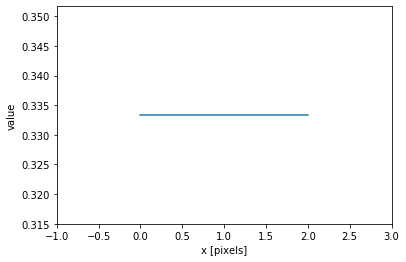

In [43]:
plt.plot(box_kernel, drawstyle='steps')
plt.xlim(-1, 3)
plt.xlabel('x [pixels]')
plt.ylabel('value')
plt.show()

We now apply the kernel to our data through the `convolve` function, passing the data as the first argument and the kernel as the second. 

In [40]:
smoothed_data_box = convolve(flux, box_kernel)

Comparing the original data to the convolved, we can see that the data has been smoothed, especially around sharp lines in the spectra.

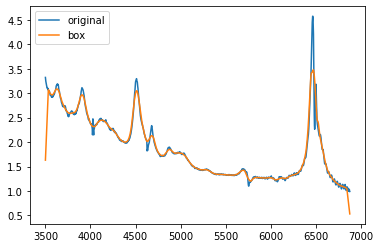

In [41]:
plt.plot(x,flux)
plt.plot(x,smoothed_data_box)
plt.legend(['original','box'],loc=2)

To change kernel just instantiate it and convolve again. Below we choose a Gaussian filter with standard deviation 5.

In [1]:
gauss_kernel = Gaussian1DKernel(5)
smoothed_data_gauss = convolve(flux, gauss_kernel)

plt.plot(x,flux)
plt.plot(x,smoothed_data_gauss)
plt.legend(['original','gauss'],loc=2)

NameError: name 'Gaussian1DKernel' is not defined

## Modeling

**Astropy** provides a comprehensive set of modelling tools. Here we will only sample some of its capabilities by doing a simple line fit on spectral data from [3C 273](https://en.wikipedia.org/wiki/3C_273), the first ever quasar identified.

We first load our typical scientific libraries, the `fits` astropy sublibrary for loading data, and the Astropy `models` and `fitting` libraries.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from astropy.io import fits
from astropy.modeling import models, fitting

The spectra is in the primary HDU of our FITS file, so we can immediately subset this and load the data. We will scale the flux values close to unity for ease of use.

In [7]:
hdu = fits.open('../data/3C_273-S-B-bcc2009.fits')[0]
flux = hdu.data / 10000

We also need to specify our wavelength range in Ångströms. The start channel and channel step are contained in the header information under the keywords *CRVAL1* and *CDELT1* respectively, which we can use to generate an array of wavelengths.

In [8]:
a = hdu.header['CRVAL1']
b = hdu.header['CRVAL1'] + hdu.header['CDELT1']*len(flux)

a,b

(3500.0, 6878.179378747945)

In [9]:
x = np.linspace(a, b, len(flux))
x

array([3500.        , 3502.25211959, 3504.50423917, ..., 6873.67513958,
       6875.92725916, 6878.17937875])

We can now plot the spectrum

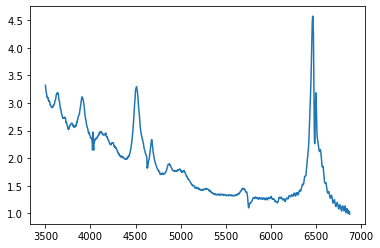

In [10]:
plt.plot(x,flux)

Now we have a spectrum with matching wavelength and flux values that we can fit a model to. We are going to attempt to fit a Gaussain to the prominent line around 6500Å. In this example we are going to use the `LevMarLSQFitter`.

In [11]:
fitter = fitting.LevMarLSQFitter()

Our model is going to consist of two elements, a 1D constant and a 1D Gaussian. For the Gaussian we specify the approximate mean around which we wish to fit. We linearly combine these elements and pass them to our `fitter` object along with the wavelength and flux arrays.

In [16]:
m = models.Const1D() + models.Gaussian1D(mean=6500)
m_new = fitter(m, x, flux)

The plot shows the model against the data. The constant model has fit the mean of all the data, and the Gaussian has moved the mean and adjusted the standard deviation to best fit the line.

This isn't the best fit. One way to improve it is to add more models.

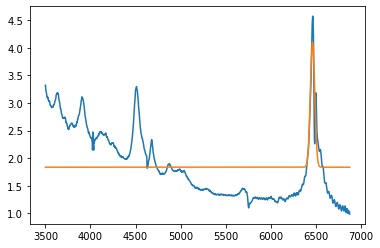

In [13]:
plt.plot(x, flux)
plt.plot(x, m_new(x))

### Compound models

Rather than the constant 1D model we use above we could use a power law to fit the slope of the spectrum better.

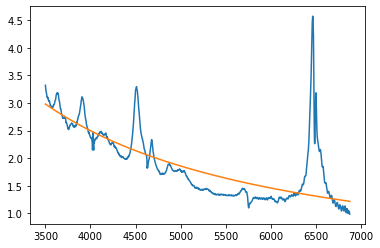

In [21]:
p1 = models.PowerLaw1D(amplitude=1.5, x_0=5500, alpha=2)
m_new = fitter(p1,x,flux)
plt.plot(x, flux)
plt.plot(x, m_new(x))

Better. We could also try to fit more than one line in the spectrum with multiple Gaussians. 

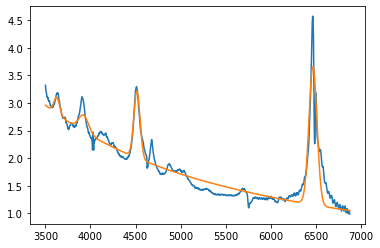

In [17]:
g1 = models.Gaussian1D(mean=6450)
g2 = models.Gaussian1D(mean=4520)
g3 = models.Gaussian1D(mean=3950)
g4 = models.Gaussian1D(mean=3600)
m = p1 + g1 + g2 + g3 + g4
m_new = fitter(m,x,flux)
plt.plot(x, flux)
plt.plot(x, m_new(x))

### 2D convolution

Two dimensional convolution proceeds similarly to one dimensional, only with a two dimensional kernel. Below we load an image of M51 and convolve it with a Gaussian. Note the keyword argument `boundary` in the call to convolve, which computes values beyond the edges of the image by extrapolating nearby values, then convolves over this extended image.

In [22]:
data = fits.getdata('../data/MESSIER_051-I-103aE-dss1.fits')

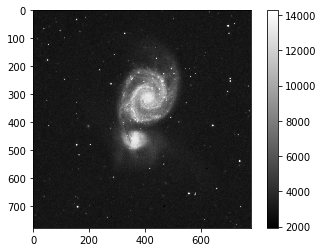

In [23]:
plt.imshow(data, cmap='gray')
plt.colorbar()

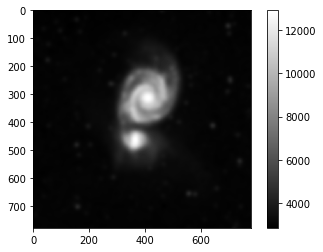

In [27]:
from astropy.convolution import Gaussian2DKernel

gauss = Gaussian2DKernel(stddev=7)
cdata = convolve(data, gauss, boundary='extend')

plt.imshow(cdata, cmap='gray',)
plt.colorbar()